# A Bayesian Approach to Smoke Alarm Detection

#### Julia Burek, Gunnar Franko, Chelsea Le Sage

On our honor, we have neither given nor received unauthorized aid on this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in data and drop irrelevant columns
data = pd.read_csv('smoke_detection_iot.csv')
data = data.drop(data.columns[0], axis = 1) # remove indexing
data = data.drop(["UTC"], axis = 1) # remove timestamp
data = data.drop(["CNT"], axis = 1) # remove count (indexing)
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# Determine how many observations the dataset contains
len(data['Fire Alarm'])

62630

In [4]:
# Determine how many observations are 1 for fire and 0 for no fire
data['Fire Alarm'].value_counts()

1    44757
0    17873
Name: Fire Alarm, dtype: int64

<AxesSubplot: title={'center': "Target Variable ('Fire Alarm') Distribution"}>

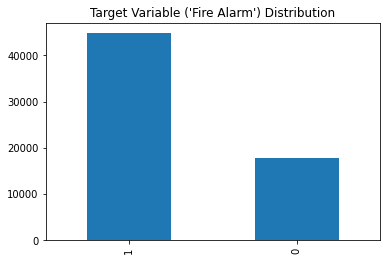

In [5]:
# Create bar plot indicating value counts of target variable, "Fire Alarm"
data['Fire Alarm'].value_counts().plot(kind='bar', title="Target Variable ('Fire Alarm') Distribution")

#### 1 -> fire present (71.46%)
#### 0 -> fire not present (28.54%)

#### The data is imbalanced with more fires present than no fire. This is important to keep in mind when interpreting results.

In [6]:
# See if there is any missing data (none)
data.isna().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

## Exploratory Data Analysis

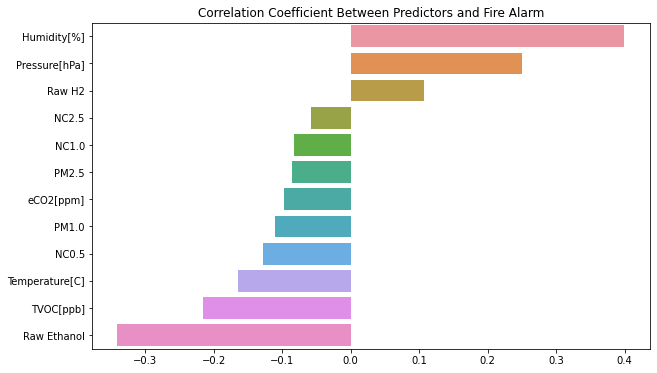

In [7]:
plt.figure(figsize=(10,6))
corr_data = data.corr()["Fire Alarm"].sort_values(ascending=False)
indices = corr_data.index
labs = []
corr = []
for i in range(1, len(indices)):
    labs.append(indices[i])
    corr.append(corr_data[i])
sns.barplot(x=corr, y=labs)
plt.title('Correlation Coefficient Between Predictors and Fire Alarm')
plt.show()

#### We see a small positive correlation between **Humidity** and the target feature, **Fire Alarm**. A change in humidity is most significant to the fire alarm.

<AxesSubplot: >

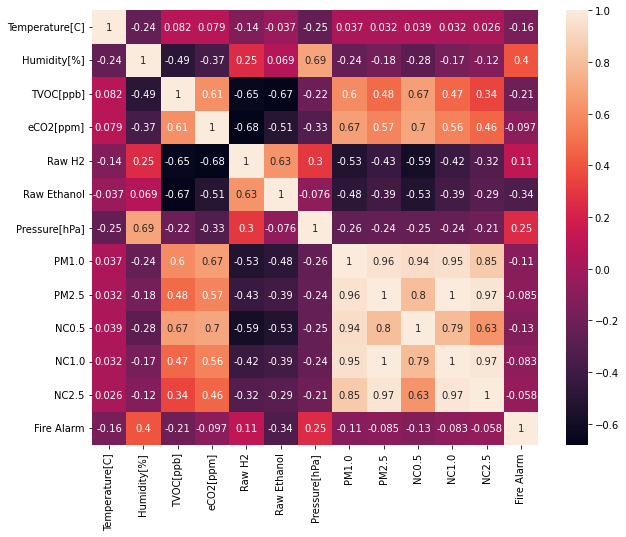

In [8]:
plt.figure(figsize = (10, 8))
sns.heatmap(data.corr(), annot = True)

#### With a correlation threshold of  ≥  0.6, we find that pressure and humidity are correlated. All PM and NC values also have high correlation amongst themselves and each other. We could remove some of these highly correlated variables to improve model size and accuracy. Humididty has the highest correlation with the target variable, indicating it may be a significant predictor.

/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


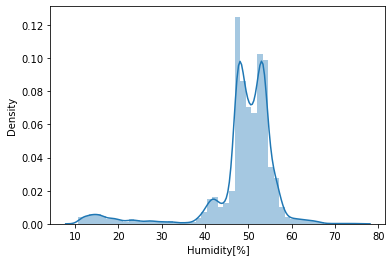

In [9]:
# Look at distribution of Humidity variable
sns.distplot(data['Humidity[%]'])
plt.show()

In [10]:
# Look at means for the different predictor variables
predictors = data.keys().drop('Fire Alarm')
data.groupby('Fire Alarm')[predictors].mean()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,19.694803,42.930077,4596.587255,962.587255,12896.316847,20082.823533,938.101383,261.982706,450.034639,1356.283816,493.872027,178.982259
1,14.483152,50.779534,882.013071,553.189356,12960.878053,19623.050428,938.837806,36.146406,78.417842,146.111337,87.665549,40.541627


In [11]:
# Look at medians for different predictor variables
data.groupby('Fire Alarm')[predictors].median()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,20.54,46.14,86.0,400.0,12837.0,20158.0,937.478,1.45,1.52,9.97,1.578,0.039
1,20.02,51.40,1103.0,404.0,12933.0,19454.0,938.878,1.87,1.94,12.86,2.005,0.045


## Posterior Marginal Probability Distributions  

In [12]:
cols = data.columns[:-1]

#Scale the data
for i in cols:
    data[i] = (data[i] - np.mean(data[i]))/np.std(data[i])

#Separate the Fires from the no Fires 
fire = data[data['Fire Alarm']==1]
nofire = data[data['Fire Alarm']==0]

a0=13
v=1
muprior = 0
xbar = []

#Get the posterior mean for variables with no fire
for i in cols:
    xbar.append(np.mean(nofire[i]))

mupost = []
for i in xbar:
    mupost.append((v*muprior + len(nofire)*i)/(v+len(nofire)))

#Get the posterior mean for variables with fire 
xbarfire = []
for i in cols:
    xbarfire.append(np.mean(fire[i]))
    
mupostfire = []
for i in xbarfire:
    mupostfire.append((v*muprior + len(fire)*i)/(v+len(fire)))

In [13]:
rprior = np.identity(12)

sneg = nofire.copy(deep=True)
for i in range(len(cols)):
    sneg[cols[i]] = sneg[cols[i]] - xbar[i]
del sneg['Fire Alarm']
sneg = sneg.to_numpy()
smatneg = np.zeros((12,12))
for i in range(len(nofire)):
    smatneg += np.multiply(np.matrix(sneg[i]), np.transpose(np.matrix(sneg[i])))
matneg = np.multiply(muprior-np.matrix(xbar), np.transpose(muprior-np.matrix(xbar)))
rpostneg = rprior + smatneg+ (v*len(nofire)/(v+len(nofire)))*matneg


spos = fire.copy(deep=True)
for i in range(len(cols)):
    spos[cols[i]] = spos[cols[i]] - xbarfire[i]
del spos['Fire Alarm']
spos = spos.to_numpy()
smatpos = np.zeros((12,12))
for i in range(len(fire)):
    smatpos += np.multiply(np.matrix(spos[i]), np.transpose(np.matrix(spos[i])))
matpos = np.multiply(muprior-np.matrix(xbarfire), np.transpose(muprior-np.matrix(xbarfire)))
rpostpos = rprior + smatpos+ (v*len(fire)/(v+len(fire)))*matpos

In [14]:
rinv = (1/len(nofire)+1/len(fire))*((len(nofire)-1)*np.linalg.inv(rpostneg) + 
                                   (len(fire)-1)*np.linalg.inv(rpostpos)) / (len(nofire)+len(fire)-2)
rpooled = np.linalg.inv(rinv)
D = abs(np.matrix(mupost) - np.matrix(mupostfire))
Tsq = D * rpooled * np.transpose(D)
pd.DataFrame({'Variables':cols,
             'Post Mean Fire':mupostfire,
             'Post Mean No Fire':mupost})

,Variables,Post Mean Fire,Post Mean No Fire
0,Temperature[C],-0.103572,0.259353
1,Humidity[%],0.252669,-0.632704
2,TVOC[ppb],-0.135700,0.339803
3,eCO2[ppm],-0.061300,0.153499
4,Raw H2,0.067619,-0.169324
5,Raw Ethanol,-0.215263,0.539037
6,Pressure[hPa],0.157850,-0.395271
7,PM1.0,-0.069859,0.174934
8,PM2.5,-0.053660,0.134369
9,NC0.5,-0.080960,0.202730


#### The two groups of posterior means are shown above. You can see that at every variable there is a pretty large difference. This indicates that it could be helfpul to determine the factors that predict the presence of a fire. 

In [15]:
import math
math.sqrt(abs(Tsq))

22598.74294476735

#### The T-score that we get is very large and this makes sense because we saw in the table above that the posterior means are quite different at each variable so it would make sense to reject equal mean vectors.

## Main Effects Logistic Regression Model (Hamiltonian Monte Carlo)

In [16]:
import pymc as pm
from pymc import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [17]:
import random

random.seed(2022)
data_samp = data.sample(n=int(data.shape[0] * .1))  # take 10% sample because of run time with full data
n = data_samp.shape[0]
nums = data_samp[predictors]
y = data_samp["Fire Alarm"]
k = 12
mean = nums.mean()
std = nums.std()
nums = np.array((nums-mean)/std)

with pm.Model() as logistic_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=np.eye(k), shape=k)
    mu = pm.math.dot(nums,beta)
    p = pm.Deterministic('p', pm.invlogit(mu))
    y_pred = pm.Bernoulli('Fire Alarm', p=pm.invlogit(mu), observed=y)
    trace_main = pm.sample(1000, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta_0, beta]
/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
/Users/juliaburek/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be sup

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 882 seconds.


array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

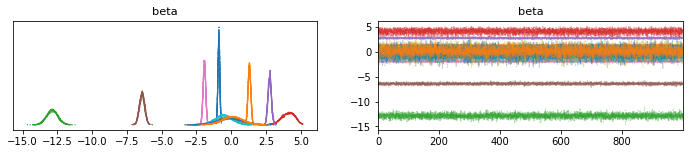

In [18]:
pm.plot_trace(trace_main, var_names=['beta'])

We see some convergence for some of the variables, but not for all. This is likely because we had to use 10% of the data.

In [19]:
import arviz as az
az.summary(trace_main, var_names=['beta_0','beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.008,1.003,-1.888,1.865,0.012,0.012,7287.0,4393.0,1.0
beta[0],-0.892,0.065,-1.023,-0.774,0.001,0.001,6999.0,5337.0,1.0
beta[1],1.304,0.097,1.125,1.485,0.001,0.001,4398.0,4972.0,1.0
beta[2],-12.870,0.398,-13.645,-12.149,0.006,0.004,4016.0,4765.0,1.0
beta[3],4.085,0.455,3.238,4.881,0.007,0.005,4728.0,4342.0,1.0
beta[4],2.759,0.119,2.544,2.996,0.002,0.001,3517.0,4371.0,1.0
beta[5],-6.411,0.184,-6.755,-6.070,0.003,0.002,3446.0,4389.0,1.0
beta[6],-1.932,0.093,-2.105,-1.755,0.001,0.001,3845.0,4930.0,1.0
beta[7],-0.337,0.851,-1.992,1.238,0.013,0.010,4633.0,4542.0,1.0
beta[8],-0.105,0.872,-1.741,1.517,0.012,0.011,5365.0,4701.0,1.0


### Accuracy of HMC Model

In [20]:
from sklearn.metrics import accuracy_score
ppc = pm.sample_posterior_predictive(trace_main, model=logistic_model)
pred_hmc = ppc['posterior_predictive']['Fire Alarm'].mean(axis=0)
y_test_pred = (pred_hmc >= 0.5).astype("int")
hmc = accuracy_score(data_samp['Fire Alarm'], y_test_pred[900])
hmc

Sampling: [Fire Alarm]


0.8982915535685774

## ADVI Model (Full)

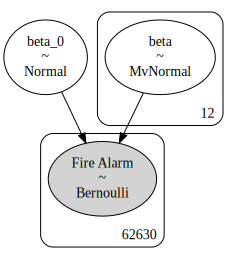

In [21]:
n = data.shape[0]
nums = data[predictors]
y = data["Fire Alarm"]
k = 12
mean = nums.mean()
std = nums.std()
nums = np.array((nums-mean)/std)

with pm.Model() as advi:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=np.eye(k), shape=k)
    mu = pm.math.dot(nums,beta) + beta_0
    y_pred = pm.Bernoulli('Fire Alarm', p=pm.invlogit(mu), observed=y)
pm.model_to_graphviz(advi)

In [22]:
with advi:
    advi_fit = pm.fit(10000, method='advi')

Finished [100%]: Average Loss = 18,921


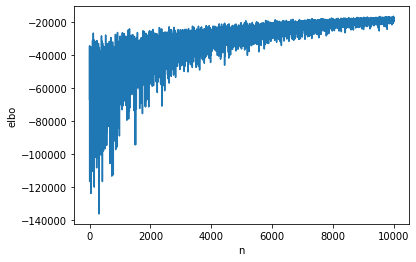

In [23]:
elbo = pd.DataFrame({'elbo': -advi_fit.hist, 'n': np.arange(advi_fit.hist.shape[0])})

plt.figure()
ax = sns.lineplot(y='elbo', x='n', data=elbo)
plt.show()

The ELBO plot shows convergence.

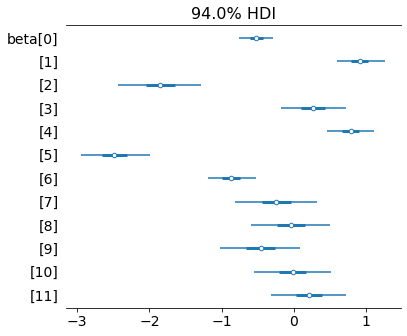

In [24]:
advi_trace = advi_fit.sample(10000)
with advi:
    pm.plot_forest(advi_trace, var_names=['beta'])

Some of the predictor variables, specifically many of the particulate matter variables straddle 0, indicating they may not be very significant in predicting the presence of a fire.

In [25]:
import arviz as az
az.summary(advi_trace, var_names=['beta_0','beta'])

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,1.152,0.146,0.869,1.419,0.001,0.001,9858.0,9798.0,NaN
beta[0],-0.520,0.128,-0.762,-0.281,0.001,0.001,9788.0,9948.0,NaN
beta[1],0.914,0.178,0.595,1.268,0.002,0.001,9370.0,9859.0,NaN
beta[2],-1.851,0.301,-2.430,-1.279,0.003,0.002,9904.0,9796.0,NaN
beta[3],0.265,0.242,-0.176,0.730,0.002,0.002,9649.0,9267.0,NaN
beta[4],0.792,0.176,0.457,1.118,0.002,0.001,9785.0,9792.0,NaN
beta[5],-2.484,0.256,-2.948,-1.990,0.003,0.002,10148.0,8763.0,NaN
beta[6],-0.870,0.177,-1.185,-0.528,0.002,0.001,9945.0,9561.0,NaN
beta[7],-0.243,0.300,-0.811,0.318,0.003,0.002,9977.0,9559.0,NaN
beta[8],-0.037,0.291,-0.586,0.499,0.003,0.002,9036.0,9182.0,NaN


### Accuracy of ADVI (full) Model

In [26]:
ppc = pm.sample_posterior_predictive(advi_trace, model=advi)
pred_advi = ppc['posterior_predictive']['Fire Alarm'].mean(axis=0)
y_test_pred = (pred_advi >= 0.5).astype("int")
advi = accuracy_score(data['Fire Alarm'], y_test_pred[5000])
advi

Sampling: [Fire Alarm]


0.8065783171004312

## ADVI Model (Reduced)

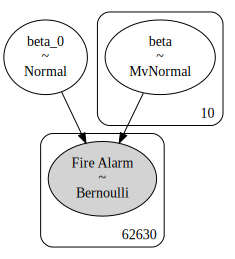

In [27]:
data2 = data.drop(["eCO2[ppm]"], axis = 1) # Remove irrelevant column based on EDA and information from Kaggle
data2 = data2.drop(["PM1.0"], axis = 1) # Remove irrelevant column based on EDA and information from Kaggle
n = data2.shape[0]
predictors2 = data2.keys().drop('Fire Alarm')
nums = data2[predictors2]
y = data2["Fire Alarm"]
k = 10
mean = nums.mean()
std = nums.std()
nums = np.array((nums-mean)/std)

with pm.Model() as advi:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=np.eye(k), shape=k)
    mu = pm.math.dot(nums,beta) + beta_0
    y_pred = pm.Bernoulli('Fire Alarm', p=pm.invlogit(mu), observed=y)
pm.model_to_graphviz(advi)

In [28]:
with advi:
    advi_fit = pm.fit(10000, method='advi')

Finished [100%]: Average Loss = 18,664


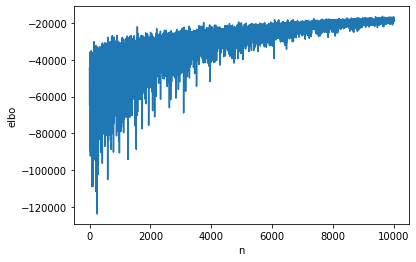

In [29]:
elbo = pd.DataFrame({'elbo': -advi_fit.hist, 'n': np.arange(advi_fit.hist.shape[0])})

plt.figure()
ax = sns.lineplot(y='elbo', x='n', data=elbo)
plt.show()

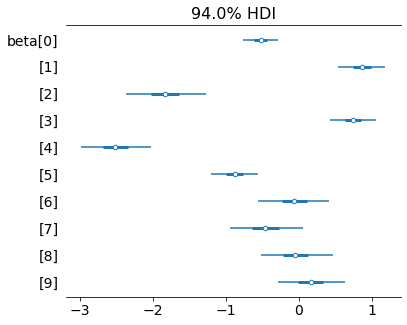

In [30]:
advi_trace = advi_fit.sample(10000)
with advi:
    pm.plot_forest(advi_trace, var_names=['beta'])

### Accuracy of ADVI (full) Model

In [31]:
ppc = pm.sample_posterior_predictive(advi_trace, model=advi)
pred_advi = ppc['posterior_predictive']['Fire Alarm'].mean(axis=0)
y_test_pred = (pred_advi >= 0.5).astype("int")
advi2 = accuracy_score(data['Fire Alarm'], y_test_pred[5000])
advi2

Sampling: [Fire Alarm]


0.7941561551971899